# Forecasting

## Exercises
The end result of this exercise should be a Jupyter notebook named **model**.

Using saas.csv or log data from API usage

# Imports

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import user, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

## 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [4]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [5]:
df.Month_Invoiced.value_counts()

2014-01-31    20000
2014-02-28    19800
2014-03-31    19599
2014-04-30    19413
2014-05-31    19221
2014-06-30    19038
2014-07-31    18851
2014-08-31    18672
2014-09-30    18494
2014-10-31    18313
2014-11-30    18145
2014-12-31    17996
2015-01-31    17829
2015-02-28    17680
2015-03-31    17530
2015-04-30    17376
2015-05-31    17225
2015-06-30    17089
2015-07-31    16951
2015-08-31    16817
2015-09-30    16671
2015-10-31    16529
2015-11-30    16387
2015-12-31    16268
2016-01-31    16142
2016-02-29    16019
2016-03-31    15895
2016-04-30    15777
2016-05-31    15685
2016-06-30    15571
2016-07-31    15460
2016-08-31    15355
2016-09-30    15240
2016-10-31    15144
2016-11-30    15049
2016-12-31    14938
2017-01-31    14840
2017-02-28    14741
2017-03-31    14665
2017-04-30    14576
2017-05-31    14475
2017-06-30    14400
2017-07-31    14312
2017-08-31    14209
2017-09-30    14131
2017-10-31    14041
2017-11-30    13985
2017-12-31    13914
Name: Month_Invoiced, dtype: int64

In [6]:
# prep the data

# convert all the column names to lowercase
df.columns = df.columns.str.lower()

# change the date from object to datetime and save it back to the date column
df.month_invoiced = df.month_invoiced.astype('datetime64')

# set sale_date as the index
df = df.set_index('month_invoiced')

#rename any messy columns that could get confusing:
df = df.rename(columns={'amount': 'quantity'})

# sort the index (sale_date)
df = df.sort_index()

# replace all the nulls with a zero
df = df.replace(np.nan,0)

In [7]:
df.subscription_type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: subscription_type, dtype: int64

We will resample to monthly aggregating our values using sum. The original granularity is monthly, but there are multiple records of the same months across multiple stores.

In [8]:
# resample by week, sum
df_resampled = df.resample('M')[['quantity']].sum()

In [9]:
df_resampled.head(2)

,quantity
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0


In [10]:
df_resampled.shape

(48, 1)

In [11]:
# look for a leap year
df_resampled.loc['2016-02-29']

quantity    51955.0
Name: 2016-02-29 00:00:00, dtype: float64

In [12]:
# Drop February 29th from our dataset (a leap year date)
# we do have a leap day in this data set, so I'm going
# to drop it out so it doesn't disrupt our annual cycle/365 count
df_resampled = df_resampled[df_resampled.index != '2016-02-29']

In [13]:
df_resampled.head(2)

,quantity
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0


## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiple by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes. 

In [14]:
.5 * df_resampled.shape[0]

23.5

In [15]:
int(.5 * len(df_resampled))

23

In [16]:
# take 50% of our data for train (round to integer for a whole number)
train_size = int(.5 * len(df_resampled))
# take 30% for validation
validate_size = int(len(df_resampled) * .3)
# get the remainder or rows for test
test_size = int(len(df_resampled) - train_size - validate_size)
# get the delineation point between validate and test by summing train and validate
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [17]:
train.shape[0] + validate.shape[0] + test.shape[0]

47

## Visualizing Our Data

Let's plot our data first, viewing where the data is split into train and test. 

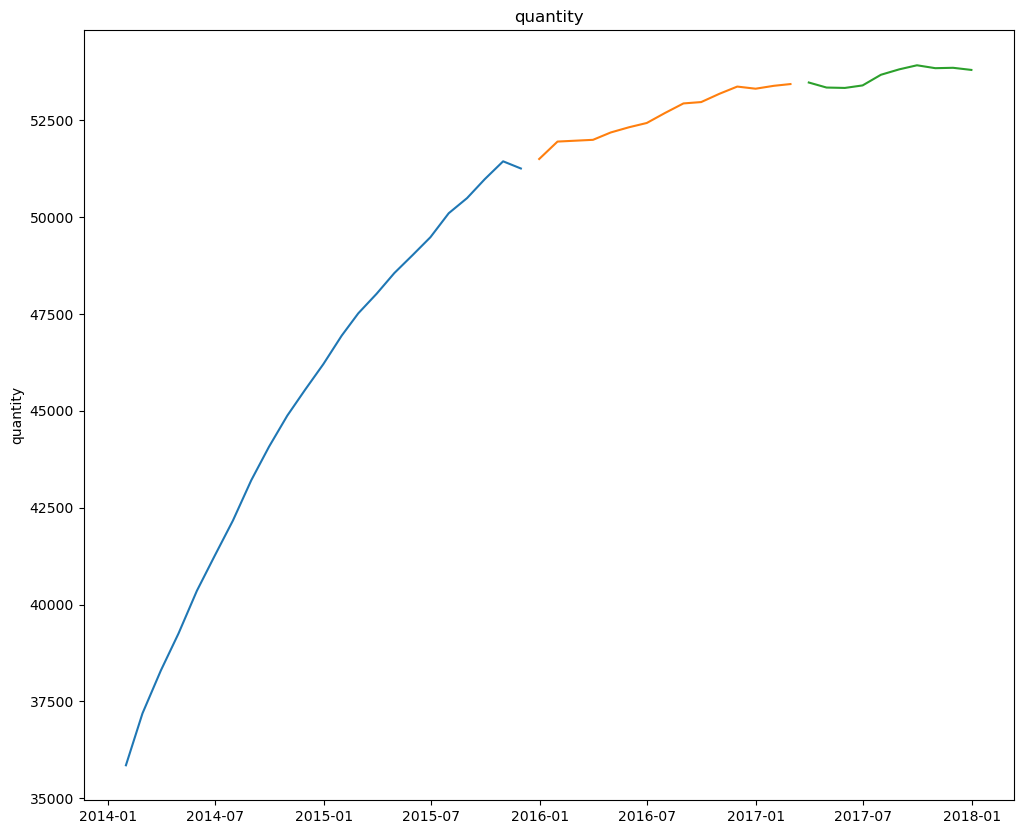

In [18]:
# plotting the values of quantity and sales over time by data subset:
for col in train.columns:
    plt.figure(figsize=(12,10))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## 2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:

## Creating Helpful Evaluation Functions

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [19]:
# evaluation function to compute rmse
# calculate an error metric on the validation's target versus predictions
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(
        sqrt(
            mean_squared_error(
            validate[target_var],
            yhat_df[target_var])
        ), 0)
    return rmse

    

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to visualize our performance to make comparisons.

In [20]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var], linewidth=1)
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, f'-- rmse: {round(rmse,2)}')
    plt.show()

In [21]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


While we could manually append the performance results of each model to this dataframe, its better to create a function that will do it for us.

`append_eval_df()` will append evaluation metrics for each model into our eval_df data frame object. This function is dependent on `eval_df` already existing, which we accomplished in our previous step.

In [22]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    return pd.concat([eval_df, pd.DataFrame(d)])

### • Last Observed Value

In [23]:
# going forward from the -1st element in train's quantity, then 
# rip out the value associated with it by taking the zeroth element of that return
train['quantity'][-1:][0]

51260.0

In [24]:
# take the last item of quantity and assign to variable

# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]

# let's make the prediction dataframe that we referenced a little earlier
yhat_df = pd.DataFrame(
    {
    'quantity': [last_quantity]
    },
    index = validate.index
)

In [25]:
yhat_df.head()

,quantity
month_invoiced,
2015-12-31,51260.0
2016-01-31,51260.0
2016-03-31,51260.0
2016-04-30,51260.0
2016-05-31,51260.0


You can see, when peeking into yhat_df, that every predicted value is the same.

***Plot Actual vs. Predicted Values***

Now, let's plot actual and predicted values using our plot_and_eval() function:

quantity -- rmse: 1559.0


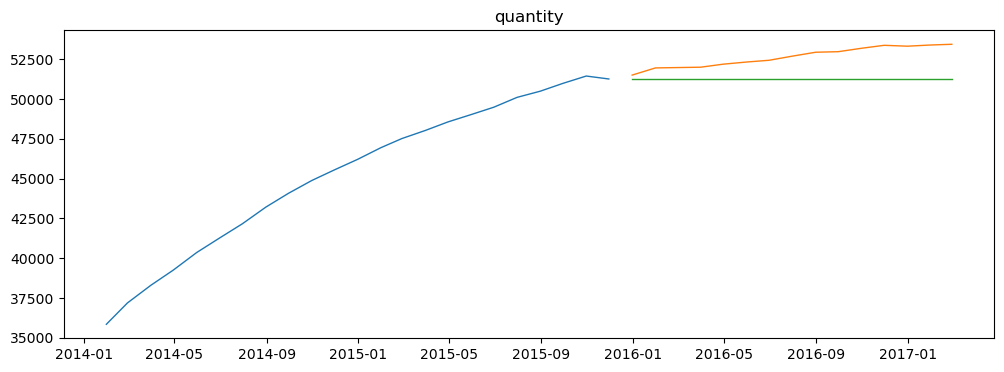

In [26]:
# use the plot and eval function we defined earlier for both targets:
for col in train.columns:
    plot_and_eval(col)

In [27]:
eval_df

,model_type,target_var,rmse


In [28]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value',
                             target_var=col)

In [29]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,1559.0


### • Simple Average


Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 


**Make Predictions**

In [30]:
# compute simple average of quantity (from train data)
avg_quantity = round(train['quantity'].mean(), 2)


yhat_df = pd.DataFrame({'quantity': [avg_quantity]},
                        index=validate.index)

yhat_df.head(3)

,quantity
month_invoiced,
2015-12-31,45310.43
2016-01-31,45310.43
2016-03-31,45310.43


### Plot Actual vs. Predicted Values

Similar to our handling of the previous baseline model, we can plot our `yhat_df` values against the actual values in validate. Our `plot_and_eval` function accomplishes this.

quantity -- rmse: 7410.0


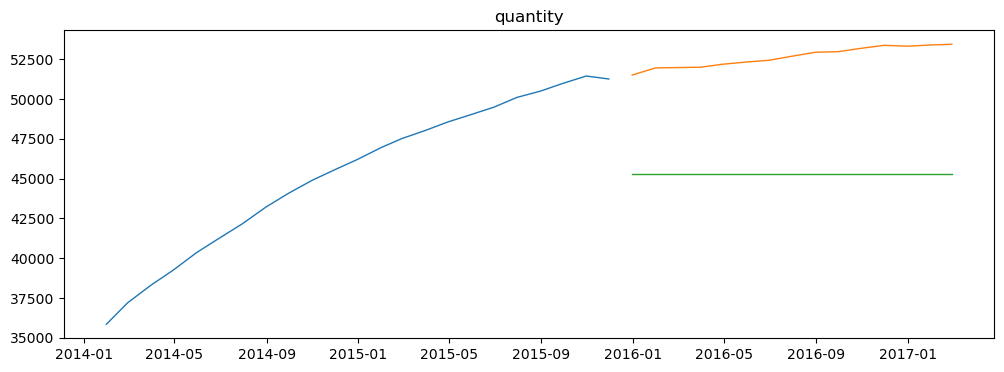

In [31]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [32]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,1559.0
0,simple_average,quantity,7410.0


### • Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average of the last period, here 30-days, will be used as the forecasted value. 

> Moving averages are moving and change over time, but only historically. Forecasts using the moving average use the average of the last period/window of time.

![moving average forecast diagram](moving_average.png)

**Make Predictions**

There are several ways to obtain the mean of the last 30 periods in train. We will use the `.rolling()` method to accomplish this.

In [33]:
train['quantity']

month_invoiced
2014-01-31    35850.0
2014-02-28    37190.0
2014-03-31    38295.0
2014-04-30    39255.0
2014-05-31    40355.0
2014-06-30    41255.0
2014-07-31    42170.0
2014-08-31    43210.0
2014-09-30    44075.0
2014-10-31    44880.0
2014-11-30    45545.0
2014-12-31    46210.0
2015-01-31    46945.0
2015-02-28    47520.0
2015-03-31    48025.0
2015-04-30    48560.0
2015-05-31    49025.0
2015-06-30    49485.0
2015-07-31    50105.0
2015-08-31    50495.0
2015-09-30    50985.0
2015-10-31    51445.0
2015-11-30    51260.0
Name: quantity, dtype: float64

In [34]:
period = 2
train['quantity'].rolling(period).mean()

month_invoiced
2014-01-31        NaN
2014-02-28    36520.0
2014-03-31    37742.5
2014-04-30    38775.0
2014-05-31    39805.0
2014-06-30    40805.0
2014-07-31    41712.5
2014-08-31    42690.0
2014-09-30    43642.5
2014-10-31    44477.5
2014-11-30    45212.5
2014-12-31    45877.5
2015-01-31    46577.5
2015-02-28    47232.5
2015-03-31    47772.5
2015-04-30    48292.5
2015-05-31    48792.5
2015-06-30    49255.0
2015-07-31    49795.0
2015-08-31    50300.0
2015-09-30    50740.0
2015-10-31    51215.0
2015-11-30    51352.5
Name: quantity, dtype: float64

In [35]:
# compute at one month rolling average, 
# use the most recent/last month period value to predict forward. 

period = 1

rolling_quantity = round(
    train['quantity'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'quantity': rolling_quantity},
                         index=validate.index)
yhat_df.head()

,quantity
month_invoiced,
2015-12-31,51260.0
2016-01-31,51260.0
2016-03-31,51260.0
2016-04-30,51260.0
2016-05-31,51260.0


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

quantity -- rmse: 1559.0


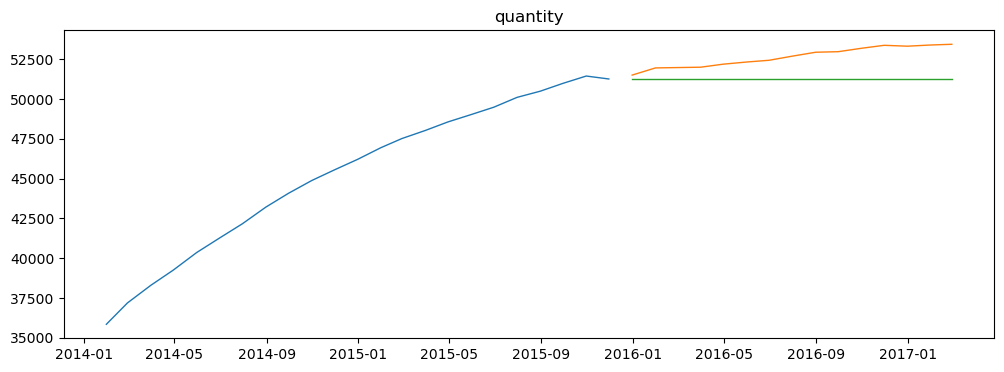

In [36]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type='1 month moving average', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,1559.0
0,simple_average,quantity,7410.0
0,1 month moving average,quantity,1559.0


Let's try out several other values for periods:

In [38]:
periods = [2, 3, 4, 6, 12, 23]

for p in periods: 
    rolling_quantity = round(
    train['quantity'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame(
        {
           'quantity': [rolling_quantity]
        },
        index=validate.index
    )
    model_type = str(p) + '_month_moving_avg'
    # lets update the eval_df (remember we have two targets!)
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                 target_var = col)

In [39]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,1559.0
0,simple_average,quantity,7410.0
0,1 month moving average,quantity,1559.0
0,2_month_moving_avg,quantity,1475.0
0,3_month_moving_avg,quantity,1587.0
0,4_month_moving_avg,quantity,1758.0
0,6_month_moving_avg,quantity,2154.0
0,12_month_moving_avg,quantity,3576.0
0,23_month_moving_avg,quantity,7410.0


Which is best so far? 

In [40]:
eval_df.groupby('target_var')['rmse'].min()

target_var
quantity    1475.0
Name: rmse, dtype: float64

In [41]:
# get the min rmse for each variable

min_rmse_quantity = eval_df.groupby(
    'target_var')['rmse'].min()[0]

In [42]:
eval_df[(eval_df.rmse == min_rmse_quantity)]

,model_type,target_var,rmse
0,2_month_moving_avg,quantity,1475.0


### • Holt's Linear Trend

![diagram of holts linear trent](holts.png)

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

In [43]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start=validate.index[0],
                                end= validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [44]:
yhat_df.head()

,quantity
month_invoiced,
2015-12-31,51696.03
2016-01-31,51946.90
2016-03-31,52442.31
2016-04-30,52686.89
2016-05-31,52929.42


**Plot Actual vs. Predicted Values**

quantity -- rmse: 888.0


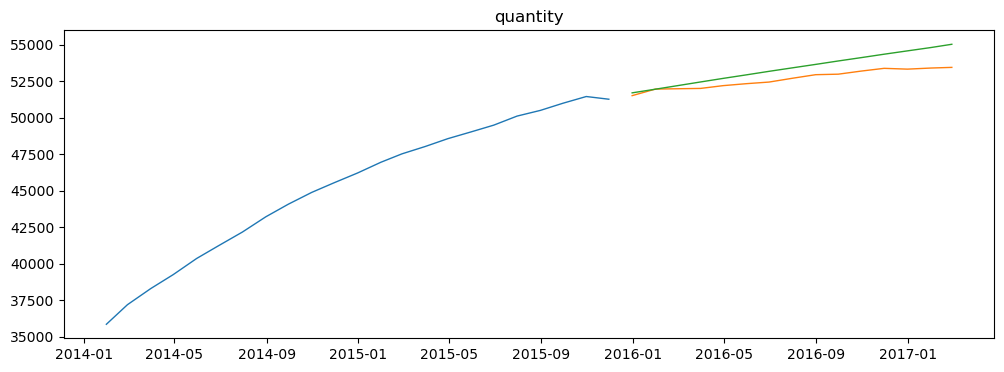

In [45]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [46]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

### • Holt's Seasonal Trend

In [47]:
import itertools

In [48]:
combos = list(itertools.product(['add','mul'],[True, False]))

In [49]:
combos

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [50]:
# let's play with some hyperparameter combinations:
hsts = {}
for col in train.columns:
    hsts[col] = {}
    for i, combo in enumerate(combos):
        hsts[col]['hst_fit_' + str(i)] = \
        ExponentialSmoothing(train[col],
                            seasonal_periods=365,
                            trend='add',
                            seasonal=combo[0],
                            damped=combo[1]).fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [ ]:
hsts.keys()

In [ ]:
hsts['']

In [ ]:
# compare our scores
best_score = 'placeholder'
for model in hsts['quantity']:
    score = sqrt(hsts['quantity'][model].sse / len(train))
    current_model = {model: score}
    if best_score == 'placeholder':
        best_score = current_model
    else:
        if list(best_score.values())[0] > list(current_model.values())[0]:
            best_score = current_model

In [ ]:
best_score

### Make Predictions

The `.forecast()` method for Holt's Seasonal models requires the number of periods the model is going to provide a prediction for **after** the end of the training data. 

In [ ]:
train.shape, validate.shape, test.shape

In [ ]:
validate.head(1)

In [ ]:
hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + 1)

In [ ]:
yhat_df = pd.DataFrame({'sales_total': hsts['sales_total']['hst_fit_1'].forecast(validate.shape[0] + 1),
                           'quantity': hsts['quantity']['hst_fit_1'].forecast(validate.shape[0] + 1)},
                          index=validate.index)
yhat_df

In [ ]:
for col in train.columns:
    plot_and_eval(col)

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [ ]:
eval_df.sort_values(by='rmse')

In [ ]:
for col in train.columns:
    plot_and_eval(col)

In [ ]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)

In [ ]:
eval_df.sort_values(by='rmse')

### • Based on previous year/month/etc., this is up to you.